## Respuesta al impulso

Describe a un sistema (física, matemàticamente o computacionalmente) por la manera en que transforma una señal de entrada y devuelve una señal de salida. Esto es particularmente útil para sistemas que son lineales e invariantes en el tiempo.

Si un sistema es lineal e invariante en el tiempo (LTI), su relación entrada-salida es completamente descripta por su respuesta al impulso $h(t)$.

![](img/ir.png)

Lo anterior es válido tanto para sistemas de tiempo continuo como sistemas de tiempo discreto.

## Convolucion

A través de la convolución podremos obtener la respuesta al impulso del sistema. Basta con utilizar como señal de entrada un impulso y registrar su salida $h(t)$ o $h[n]$.

Luego, para cualquier señal que ingrese al sistema, la salida puede encontrarse siempre por medio de la siguiente convolución: $x[n]∗h[n]$.

![](img/respuesta_general.png)


## Ejemplo de uso: auralizacion

La **auralización** es un procedimiento diseñado para modelar y simular la experiencia de fenómenos acústicos renderizados como un campo sonoro en un espacio virtualizado. Esto es útil para simular la respuesta de estructuras arquitectónicas, salas de conciertos y espacios públicos, así como para crear entornos sonoros para sistemas de inmersión virtual.
El proceso consiste en convolucionar eventos acústicos registrados 'secos' (o en una cámara anecoica) con un modelo virtual de un espacio acústico, cuyas características se determinan por su respuesta impulsiva (IR).

In [1]:
import scipy.io.wavfile as wav
from scipy.signal import resample
import matplotlib.pyplot as plt
import numpy as np

Pongamos a prueba esto con un ejemplo. Vamos a convolucionar una grabación de guitarra anecoica con un impulso real grabado. 

* Impulso descargado del sitio [EchoThief](http://www.echothief.com/)
* Grabación anecoica descargada de [TH Köln](http://audiogroup.web.th-koeln.de/anechoic.html)

In [2]:
fs1, guitar_audio = wav.read('audio/Flamenco2_U89.wav')

<ipython-input-2-ce1ddce7b3d6>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs1, guitar_audio = wav.read('audio/Flamenco2_U89.wav')


In [3]:
t1 = np.linspace(0, fs1 / guitar_audio.size, guitar_audio.size)

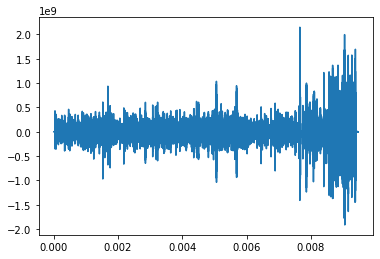

In [4]:
plt.plot(t1, guitar_audio)

In [5]:
fs2, ir = wav.read('audio/HaleHolisticYogaStudio.wav')
ir = ir[:,0] + ir[:,1] 
t2 = np.linspace(0, fs2 / ir.size, ir.size)

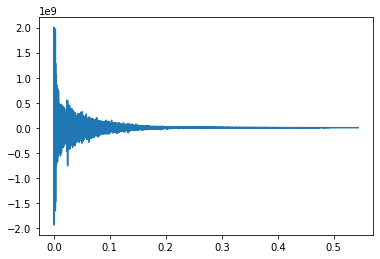

In [6]:
plt.plot(t2, ir)

Las señales tienen **diferente frecuencia de muestreo**, por lo que debemos procesar alguna de ellas para remuestrearla con la misma frecuencia que la otra.

In [7]:
fs1, fs2

(48000, 44100)

Vamos a remuestrear el impulso para que tenga la misma frecuencia de muestreo:

In [8]:
ir, t2 = resample(ir, fs1//fs2 * ir.size, t2)

Ahora que tenemos las señales vamos a proceder a auralizar. Con la función `np.convolve` podemos realizar la operación en el dominio del tiempo. Veamos...

In [ ]:
#guitar_auralizada = np.convolve(guitar_audio[0:], ir)

La operación tarda demasiado, esto se debe a que la cantidad de cálculos que tiene que hacer es de una magnitud muy grande, incluso para una computadora. Si vemos la cantidad de muestras de las señales podemos notar que la grabación anecoica tiene aproximadamente 5 millones de muestras y el impulso tiene algo más de 80 mil. Esto significa que la computadora tendrá que operar unas 80 mil veces con una señal que tiene unas 5 millones de muestras.

In [9]:
guitar_audio.size, ir.size

(5066548, 81129)

La manera de evitar este problema es operar en el dominio de la frecuencia. Aplicando la transformada de Fourier a ambas señales pasamos del dominio temporal al frecuencial. Una de las propiedades de la convolución es que, al pasar al dominio frecuencial, las señales se multiplican. En otras palabras, la convolución en tiempo es la multiplicación en frecuencia. El paquete **scipy** posee la función **fftconvolve** que nos permite operar con la convolución en el dominio de la frecuencia directamente. Sólo se necesita indicar las señales que vamos a convolucionar.

In [10]:
from scipy.signal import fftconvolve

In [11]:
guitar_auralizada = fftconvolve(guitar_audio, ir)

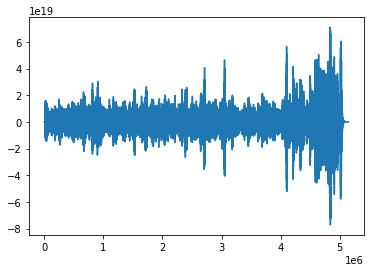

In [12]:
plt.plot(guitar_auralizada)

Ya tenemos nuestra señal auralizada. Ahora la normalizamos para poder guardarla en un archivo `.wav`. 

In [14]:
guitar_auralizada = guitar_auralizada/guitar_auralizada.max()
wav.write('audio/guitarra_auralizada.wav', fs1, guitar_auralizada)

# Metodo de obtencion de respuesta al impulso

Se obtiene su respuesta al impulso $h(t)$, aplicando un *sine sweep exponencial* como señal de excitación $x(t)$, la cual se representa por la siguiente ecuación.
    
\begin{equation}
    x(t) = sin\bigg[\frac{w_1 \cdot T}{\ln{(\frac{w_2}{w_1})}}(e^{\frac{t}{T}\ln{(\frac{w_2}{w_1})}}-1)\bigg]
\end{equation}

La señal comienza con una frecuencia angular $w_1$ y termina con una frecuencia angular $w_2$, y su duración es de $T$ segundos. Al \textit{sine weep} le corresponde un filtro inverso $f(t)$ tal que la convolución entre ambas señales cumpla con lo definido en la ecuación \ref{ec-filtinverso}.

\begin{equation}\label{ec-filtinverso}
    x(t) \circledast f(t) = \delta (t)
\end{equation}

Donde $\delta (t)$ es la función impulso. Al convolucionar el filtro inverso con la respuesta del \textit{DBP} $y(t)$, se obtiene su respuesta al impulso $h(t)$, tal como se observa en la ecuación \ref{ec-impulsosistema}. Para cumplir con esta condición, se asume que la medición se realiza en un entorno anecoico o en campo libre, por lo que no hay aporte de la sala en la respuesta obtenida. Esto significa que, siendo $h(t)$ la respuesta del dispositivo y de la sala ($h(t) = h_{sala}(t) + h_{DBP}(t)$), despreciamos $h_{sala}(t)$ debido a que se aproxima a $\delta(t)$. Si se opera en el dominio frecuencial (aplicando la transformada discreta de Fourier), la respuesta al impulso $H(jw)$ se obtiene del producto entre las funciones $Y(jw)$ y $F(jw)$, como se puede ver el la ecuación \ref{ec-impulsofrec}. El flujo de las señales y los cálculos aplicados por el método se representan en el diagrama de la Figura \ref{dia:metodo-mic-frecuencia}.

\begin{equation}\label{ec-impulsosistema}
    h(t) = y(t) \circledast f(t)
\end{equation}
\begin{equation}\label{ec-impulsofrec}
    H(jw) = Y(jw) \cdot F(jw)
\end{equation}

In [15]:
from scipy.signal import chirp

In [16]:
fs = 48000
T= 1/fs
duracion = 10
t = np.arange(0, duracion, T)
f1 = 20
f2 = 20000

ess = chirp(t, 20, duracion-1, 20000, 'logarithmic')

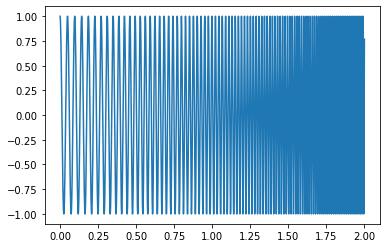

In [17]:
plt.plot(t[0:2*fs], ess[0:2*fs])

In [18]:
wav.write('audio/sweep.wav', fs, ess)

Cuando esta señal es reproducida en un recinto, aparecen modulaciones en amplitud propias de la respuesta de la sala. El recinto es el sistema cuya respuesta queremos obtener. El código a continuación pretende emular una señal real grabada por un micrófono. Ésta será nuestra $y(t)$ o salida del sistema.

In [19]:
rand = np.random.random(ess.size)/5
decay = np.exp(-t*0.6) * np.sin(2*t)
ess_grabada = ess*(rand+decay)
ess_grabada = ess_grabada / ess_grabada.max()

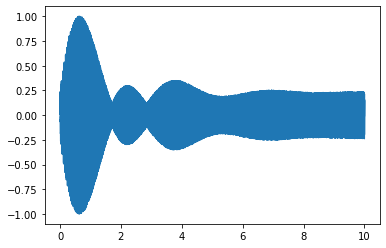

In [20]:
plt.plot(t, ess_grabada)

Por otro lado, necesitamos obtener el filtro inverso, que se calcula en el dominio de la frecuencia, considerando la siguiente equivalencia:

\begin{equation}
    x(t) * f(t) = \delta(t)  \rightarrow X(jw) \cdot F(jw) = 1
\end{equation}

De esto se desprende que $F(jw) = 1/X(jw)$

In [21]:
from scipy.fftpack import fft, ifft

In [22]:
ESS = fft(ess)
FILT_INVERSO = 1/ESS
filt_inverso = ifft(FILT_INVERSO)

/home/fabricio.chungo/Documents/Python/otros/SyS/venv-sys/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


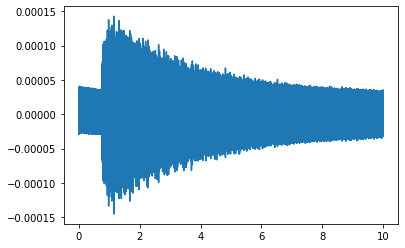

In [23]:
plt.plot(t, filt_inverso)

Comprobamos que el filtro inverso convolucionado con $x(t)$ me da un impulso unitario $\delta(t)$.

In [24]:
imp = fftconvolve(ess, filt_inverso)

/home/fabricio.chungo/Documents/Python/otros/SyS/venv-sys/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


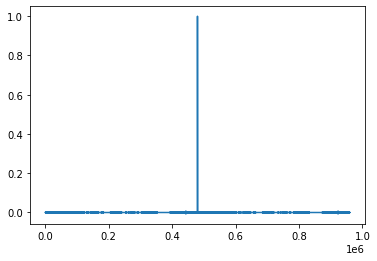

In [25]:
plt.plot(imp)

Finalmente, aplicamos la convolución en tiempo (multiplicación en frecuencia) entre la señal $y(t)$ y la señal $f(t)$. Esto nos va a dar la respuesta del sistema $h(t)$. 

In [26]:
respuesta_impulso = fftconvolve(ess_grabada, filt_inverso)

/home/fabricio.chungo/Documents/Python/otros/SyS/venv-sys/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


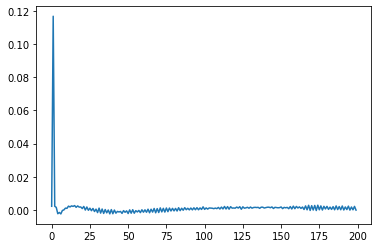

In [27]:
#plt.plot(respuesta_impulso)
plt.plot(respuesta_impulso[respuesta_impulso.size//2: respuesta_impulso.size//2 +200])

## Referencias

* "Signals and Systems", Alan V. Oppenheim, Alan S. Willsky.
* Documentación de [Scipy](https://www.scipy.org/).
* Farina, Angelo. "Advancements in impulse response measurements by sine sweeps." Audio Engineering Society Convention 122. Audio Engineering Society, 2007. [Link](https://www.aes.org/e-lib/online/browse.cfm?elib=14106)
* IMPULSE RESPONSE MEASUREMENTS BY MEASUREMENTS BY EXPONENTIAL SINE SWEEPSEXPONENTIAL SINE SWEEPS. Angelo Farina. WorkshopCasa della MusicaParma, 18 October 2008. [Link](http://pcfarina.eng.unipr.it/Public/Presentations/audioprecision-workshop.pdf)
